In [276]:
import json

import pandas as pd
import spacy

import numpy as np

from collections import Counter, defaultdict
from itertools import chain
import re

import arrow 

import googlemaps

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go

import cufflinks as cf

import scattertext as st
from scattertext import word_similarity_explorer

from gender import GenderDetector

In [277]:
nlp = spacy.load('en')

nlp.Defaults.stop_words |= {'probably'}
STOPWORDS = nlp.Defaults.stop_words

In [278]:
init_notebook_mode(connected=True)

In [294]:
class T:
    
    def __init__(self, review_file, users_file, attract_file, impute_country=False, impute_gender=False):
        
        """
        collected TripAdvisor data comes as JSONs; this class does some data processing including imputation
        """

        self.r = json.load(open(review_file))
        self.u = json.load(open(users_file))
        self.a = json.load(open(attract_file))  

        # convert everything to pandas
        self.u_df = pd.DataFrame(self.u).dropna(subset=['name'])
        
        self.r_df = pd.DataFrame(self.r).dropna(subset=['attr_id'])

        self.tag_cols = list(set([tg for tg in chain.from_iterable(self.u_df['tags'])]))
        
        if impute_country:
            self.gmaps = googlemaps.Client(key=open('creds/geocoding_api.key').readline().strip())
        if impute_gender:
            self.gd = GenderDetector()
            
        self.genders = ['all', 'm', 'f']
        self.age_groups = ['all'] + sorted([ag for ag in set(self.u_df['age']) if '-' in str(ag)], 
                                           key=lambda x: int(x.split('-')[0]))
#         self.tourist_types = ['all'] + [c for c in self.u_df.columns if {'yes', 'no'} <= set(self.u_df[c])]
    
    def stats(self):
        
        self.user_stats = defaultdict(list)
        
        self.review_ids = set()
        self.attr_ids = set()
        self.user_names = set()
        self.dates_exp = set()
        
        for r in self.r:
            
            self.review_ids.add(r['id'])
            self.attr_ids.add(r['attr_id'])
            self.user_names.add(r['by_user'])
            
            if r['date_of_experience']:
                self.dates_exp.add(arrow.get(r['date_of_experience'], 'MM/YYYY'))
        
        print(f'DATA\n{"".join(["-"]*4)}')
        print('{:,} reviews written between {} and {} for {:,} attractions by {:,} users' \
                  .format(len(self.review_ids), 
                          min(self.dates_exp).format("MM/YYYY"), 
                          max(self.dates_exp).format("MM/YYYY"), 
                          len(self.attr_ids), 
                          len(self.user_names)))
        
        for u in self.u:
            for attr in 'tags age gender name'.split():   
                if u[attr]:
                    self.user_stats[attr].append(u[attr])
        
        print('user attribute availability:')
        print(' ~ '.join(['{}: {:,} ({:.1f})%'.format(attr, 
                                                    len(self.user_stats[attr]), 
                                                    100*len(self.user_stats[attr])/len(self.user_stats['name'])) 
                                                       for attr in 'tags age gender'.split()]))
              
        return self
        
    def _tags_to_cols(self, tag_list):
        
        if not tag_list:
            return [None]*len(self.tag_cols)
        
        return ['yes' if tag in tag_list else 'no' for tag in self.tag_cols]
    
    def tags_to_cols(self):
        
        self.u_df = pd.concat([self.u_df, 
                            pd.DataFrame(self.u_df['tags'].apply(self._tags_to_cols).to_list(), 
                                         columns=self.tag_cols)], axis=1).drop('tags', axis=1)
        
        return self

              
    def _fix_location(self, s):
              
        """
        using Google Geocoding API to clarify users location
        """
        
        loc = dict()
        
        if not (isinstance(s, str) and s.strip()):
            print('geocoding API needs a string argument!')
            return loc
        
        geocode_result = self.gmaps.geocode(s)
        
        # take only the top result
        if geocode_result:
            res = geocode_result[0]
        else:
            print(f'geocoding api can\'t find this location: {s}!')
            return loc
        
        if 'address_components' in res:
            for _ in res['address_components']:
                if 'country' in _['types']:
                    loc.update({'country': _['long_name']})
                if 'locality' in _['types']:
                    loc.update({'locality': _['long_name']})
        if 'formatted_address' in res:
            loc.update({'location': res['formatted_address']})
        
        try:
            loc.update({'coordinates': res['geometry']['location']})
        except:
            pass
        
        if not loc:
            print('locationd fields couldn\'t be retrieved from geocoding result!')
                               
        return loc

    
    def impute_location(self):
        
        self.countries = {_['name'].lower() for _ in json.load(open('data/countries.json'))}
              
        localities = []
        countries = []
    
        c_geo = 0
              
        in_str = lambda s1, s2: ' ' + s1 + ' ' in ' ' + s2 + ' '
        
        for i, row in enumerate(self.u_df.iterrows(), 1):
                               
            users_country = None
              
            if isinstance(row[1].location, str):
              
                loc_str = ' '.join(re.sub(r'[\-\_]', ' ', row[1].location).split()).lower()

                _found_countries = set()

                for country in self.countries:
                    if in_str(country, loc_str):
                        _found_countries.add(country.title())

                if len(_found_countries) == 1:
                    users_country = _found_countries.pop()
                else:
                  # run geolocation
                  r = self._fix_location(loc_str)
                  c_geo += 1
              
                  if 'country' in r:
                     users_country = r['country']
            
            print(f'#{i}: location: {row[1].location} -> country: {users_country}')
            
            countries.append(users_country)
                               
        self.u_df['country'] = countries
              
        print(f'ran geolocation {c_geo} times ({100*c_geo/len(self.u_df):.1f}%)')
        
        return self
    
    def _impute_gender(self, s):
        
        # separate nicknames like TrevorJ into trevor J; or Mike23 into Mike 23
        s = re.sub(r'([a-z]{1})([A-Z0-9]+)', r'\1 \2', s)
        
        return self.gd.gender(s)
    
    def impute_gender(self):
        
        self.u_df['gender'] = self.u_df['gender'] \
                                .apply(lambda s: s if str(s) in 'm f'.split() else self._impute_gender(str(s)))
        return self
    
    def merge_data(self):
        
        self.data = self.r_df.join(self.u_df.set_index('name'), on='by_user', how='inner')
        
        return self
    
    def selector(self, req_dict):

        """
        return a data frame obtained from the original one (df) by filtering out all rows that don't match
        the required values provided in the dictionary req_dict which looks like, for example, 
        {'age': '13-17', 'gender': 'f',...}

        what if after all the filtering all that's left is an empty data frame? then just return that empty data frame
        """

        if self.data.empty:
            print('dataframe you\'re trying to select from is empty!')
            return self

        actual_cols = set(self.data.columns) | {'tourist_type'}
        required_cols = set(req_dict)

        if not (required_cols <= actual_cols):
            cols_na = ', '.join(required_cols - actual_cols)
            raise Exception(f'column(s) {cols_na} you\'re asking for are not available!')

        out = self.data

        for col in required_cols:

            if req_dict[col] != 'all':

                if col != 'tourist_type':
                    out = out[out[col].astype(str) == req_dict[col]]
                else:
                    out = out[out[req_dict[col]] == 'yes']
                if out.empty:
                    print('dataframe you\'re trying to select from became empty!')
                    break

        return out
              
    def prepr_(self, review_text):
    
        review_ = defaultdict(list)
        review_['original'] = review_text
        
        doc = nlp(review_text)
              
        review_['ents'] = [e.text for e in doc.ents]
        review_['labels'] = [e.label_ for e in doc.ents]
              
        review_text = review_text.lower()
        doc = nlp(review_text)
              
        review_['lemmatised'] = ['$' if w.is_currency else w.lemma_ for w in doc if not any([w.is_stop, w.is_punct, len(w.lemma_) < 1])]
        review_['nouns'] = [w.lemma_ for w in doc if w.pos_ == 'NOUN']
        review_['verbs'] = [w.lemma_ for w in doc if w.pos_ == 'VERB']
        
        return review_
              
    def get_textdata(self, seg1_dict, seg2_dict, min_frq=5):
               
        seg1_df = self.selector(seg1_dict)
        seg1_df['segment'] = 'seg1'
              
        seg1_df['lemmatised'] = seg1_df.text.apply(lambda x: ' '.join(self.prepr_(x)['lemmatised']))
              
        seg2_df = self.selector(seg2_dict)
        seg2_df['segment'] = 'seg2'
              
        seg2_df['lemmatised'] = seg2_df.text.apply(lambda x: ' '.join(self.prepr_(x)['lemmatised']))
              
        self.text_data = pd.concat([seg1_df[['lemmatised', 'segment']], seg2_df[['lemmatised', 'segment']]])
        
        corpus = st.CorpusFromPandas(self.text_data, category_col='segment', 
                                                 text_col='lemmatised', nlp=nlp).build()
              
        self.freq_data = corpus.get_term_freq_df().rename(columns={'seg1 freq': 'seg1_frq', 'seg2 freq': 'seg2_frq'})
        self.freq_data['s1_score'] = corpus.get_scaled_f_scores('seg1')
        self.freq_data['s2_score'] = corpus.get_scaled_f_scores('seg2')
              
        # impose min frequency
        self.freq_data = self.freq_data[(self.freq_data['seg1_frq'] >= min_frq) & (self.freq_data['seg2_frq'] >= min_frq)]
        print(f'{len(self.freq_data):,} words occur at least {min_frq} times')
              
        sc = np.vectorize(lambda s1, s2: 2*(-0.5+(s1 if s1>s2 else 1-s2 if s2>s1 else 0)))
              
        self.freq_data['nfsc'] = sc(self.freq_data['s1_score'], self.freq_data['s2_score'])
              
        # scale frequencies
        seg1_frq_min, seg1_frq_max = self.freq_data['seg1_frq'].min(), self.freq_data['seg1_frq'].max()
        seg2_frq_min, seg2_frq_max = self.freq_data['seg2_frq'].min(), self.freq_data['seg2_frq'].max()
              
        self.freq_data['seg1_frq_sc'] = (self.freq_data['seg1_frq'] - seg1_frq_min)/(seg1_frq_max - seg1_frq_min)
        self.freq_data['seg2_frq_sc'] = (self.freq_data['seg2_frq'] - seg2_frq_min)/(seg2_frq_max - seg2_frq_min)
              
        # filename to save as .csv
        fn = ['textdf']
        
        for sdik in [seg1_dict, seg2_dict]:
              
              _ = ''
            
              for attr in 'age gender tourist_type country'.split():
              
                   _ += attr[0].upper() + (sdik[attr] if attr in sdik else '1')
              
              fn.append(_.replace(' ','').replace('-','')) 
              
        self.freq_data.to_csv('data/' + '_'.join(fn) + '.csv')
        
        return self
        

In [295]:
if __name__ == '__main__':
    
    t = T(review_file='data/reviews_melb_06032019.json',
         users_file='data/reviewers_melb_06032019.json',
         attract_file='data/attractions_melbourne.json') \
                .stats().tags_to_cols() \
                .merge_data() \
                .get_textdata(seg1_dict={'gender': 'm', 'age': '50-64'}, 
                              seg2_dict={'tourist_type': 'like a local'})

DATA
----
18,962 reviews written between 12/2010 and 03/2019 for 65 attractions by 12,001 users
user attribute availability:
tags: 2,779 (23.2)% ~ age: 4,238 (35.3)% ~ gender: 5,409 (45.1)%
1,921 words occur at least 5 times


In [296]:
TAKE = 300

df = t.freq_data.sort_values('seg1_frq', ascending=False)

s1_tb, s1_tu = df['seg1_frq_sc'].quantile(q=[0.20, 0.95])
s2_tb, s2_tu = df['seg2_frq_sc'].quantile(q=[0.20, 0.95])

df = df[((df['seg1_frq_sc'] < s1_tu) & (df['seg1_frq_sc'] > s1_tb)) & 
        ((df['seg2_frq_sc'] < s2_tu) & (df['seg2_frq_sc'] > s2_tb))].iloc[:TAKE]

colorscale=[[0, 'orange'], [1, '#2C72EC']]

layout= go.Layout(
#     title= 'Characteristic Words',
    hovermode= 'closest',
    xaxis= dict(
        title='Frequency in Reviews by Seg 1',
        ticklen= 5,
        tickmode='array',
        tickvals=np.linspace(df['seg1_frq_sc'].min(), df['seg1_frq_sc'].max(), num=5),
        ticktext=['low', '', 'medium', '', 'high'],
        zeroline= False,
        gridwidth= 2,
        showticklabels=True,
        showgrid=True,
    ),
    yaxis=dict(
        ticklen= 5,
        tickmode='array',
        tickvals=np.linspace(df['seg2_frq_sc'].min(), df['seg2_frq_sc'].max(), num=5),
        ticktext=['low', '', 'medium', '', 'high'],
        gridwidth= 2,
        zeroline=False,
        showticklabels=True,
        showgrid=True,
        tickangle=-90,
        title='Frequency in Reviews by Seg 2',
    ),
    legend=dict(orientation="h", x=0.5, y=1.1, yanchor="top"),
    annotations=[dict(text='Stronger Association with ', x=0.39, y=1.08, 
            showarrow=False, 
            xref="paper",
            yref="paper",
            yanchor="top"
                     )],
    showlegend= True
)

df_neg = df[df['nfsc']<0]
df_pos = df[df['nfsc']>0]

trace0 = go.Scatter(
    name='Seg1',
    x = df_neg['seg1_frq_sc'],
    y = df_neg['seg2_frq_sc'],
    mode = 'markers',
    hoverinfo='text', 
    marker=dict(
                color='orange', 
                size=10,
                opacity=0.85,
               ),
    text= df_neg.index)

trace1 = go.Scatter(
    name='Seg2',
    x = df_pos['seg1_frq_sc'],
    y = df_pos['seg2_frq_sc'],
    mode = 'markers',
    hoverinfo='text', 
    marker=dict(
                color='#2C72EC', 
                size=10, 
                opacity=0.85,
               ),
    text= df_pos.index)


fig= go.Figure(data=[trace0, trace1], layout=layout)

In [297]:
df.head(3)

,seg1_frq,seg2_frq,s1_score,s2_score,nfsc,seg1_frq_sc,seg2_frq_sc
term,,,,,,,
crown,94,106,0.917900,0.082100,0.835800,0.095391,0.083333
venue,93,93,0.934247,0.065753,0.868495,0.094319,0.072607
great place,92,113,0.905559,0.094441,0.811118,0.093248,0.089109


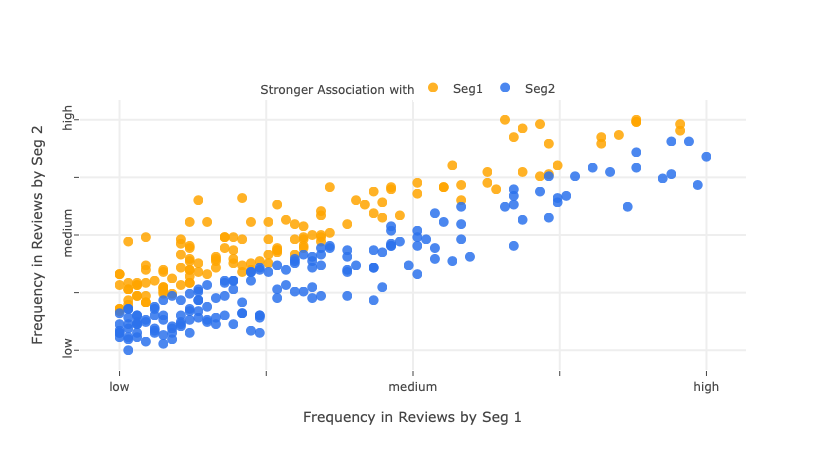

In [298]:
iplot(fig)